# Redes Neuronales para clasificación de datos no balanceados

Éste es un notebook sobre clasificación de datos no-balanceados. Se utilizarán ANN combinadas con métodos de remuestreo y ensamble. 

El conjunto de datos utilizado es una versión modificada del "Breast Cancer Wisconsin":

https://www.kaggle.com/uciml/breast-cancer-wisconsin-data (48kb)

Outline: 
    
1. Carga de módulos y datos
2. Exploración inicial de atributos y valores nulos
4. Relaciones entre atributos
5. Selección de variables
6. Análisis de componentes principales
7. Modelado
    - Definición inicial de la arquitectura y ajuste de parámetros
    - Análisis de las variables de entrada
    - Modelo de base
    - Métodos de remuestreo
        - Sobremuestreo
        - Submuestreo
        - Limpieza
        - Mixtos
    - Métodos de ensamble    

## 1. Carga de módulos y carga de datos

### Módulos de sistema

In [56]:
import sys
import re
from __future__ import print_function
from __future__ import unicode_literals
from time import sleep
import logging

# Muestra los logs de progreso en el stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

### Módulos de análisis numérico

#### Básicos de análisis numérico

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import interp
from collections import Counter

#### Modelado

In [58]:
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from imblearn import over_sampling
from imblearn import under_sampling
from imblearn import ensemble
from imblearn import combine
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier

### Configuración

In [59]:
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", None)

%matplotlib inline
np.set_printoptions(precision=4)
sns.set(context='notebook', palette='deep')
LW = 1

RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

### Carga de datos

In [60]:
df = pd.read_csv('wisconsin_bcd_unbalanced.csv', index_col=0)

In [61]:
feature_names = df.columns
y = df['class'].values
X = df.as_matrix([feature for feature in feature_names if feature not in ['class']])

## 2. Exploración inicial de atributos

#### Forma del conjunto de datos

In [62]:
print('El conjunto de datos utilizado tiene {columns} columnas y {rows} filas'.format(columns=df.shape[1], rows=df.shape[0]))

El conjunto de datos utilizado tiene 31 columnas y 528 filas


In [63]:
df.head(1)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
0,18.01,20.56,118.4,1007.0,0.1001,0.1289,0.117,0.07762,0.2116,0.06077,0.7548,1.288,5.353,89.74,0.007997,0.027,0.03737,0.01648,0.02897,0.003996,21.53,26.06,143.4,1426.0,0.1309,0.2327,0.2544,0.1489,0.3251,0.07625,1.0


#### Tipo de datos

In [64]:
df.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

#### Distribución de la variable de clase

Hay 20 instancias para la clase M y 508 instancias para la clase B.
El Ratio de Prevalencia de la clase positiva (PPR) es de 0.04


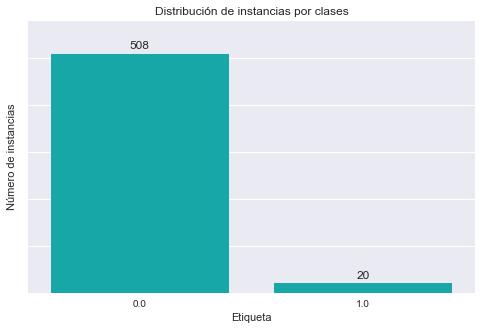

In [10]:
plt.figure(figsize=(8,5))
ax = sns.countplot(x="class", data=df, color="c");
plt.title('Distribución de instancias por clases')
plt.ylabel('Número de instancias')
plt.xlabel('Etiqueta')
plt.ylim([0, df.shape[0]+50])
ax.set_yticklabels([])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            '{:1.0f}'.format(height),
            ha="center",
            ) 
print('Hay {:.0f} instancias para la clase M y {:.0f} instancias para la clase B.'.format(y.sum(), y.shape[0] - y.sum()))
print('El Ratio de Prevalencia de la clase positiva (PPR) es de {:.2f}'.format(float(y.sum()) / y.shape[0]))

### Descripción estadística básica

#### Estadísticos

In [11]:
df.describe()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,class
count,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000,528.000000
mean,13.764089,19.334527,89.428466,616.990341,0.095967,0.101056,0.082444,0.045255,0.180914,0.063005,0.383039,1.235332,2.700543,36.530205,0.007080,0.024743,0.031192,0.011618,0.020608,0.003770,15.718862,25.667424,103.420038,814.987121,0.131360,0.244560,0.257428,0.108461,0.288967,0.083586,0.037879
std,3.275388,4.594760,22.535032,317.186286,0.014312,0.051075,0.077089,0.036711,0.027790,0.006951,0.256347,0.572480,1.815829,40.238697,0.003085,0.017393,0.030732,0.006262,0.007830,0.002658,4.419500,6.439843,30.720383,508.900865,0.022882,0.152673,0.204832,0.063326,0.061664,0.017976,0.191084
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.050960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.600000,16.020000,74.307500,409.075000,0.085403,0.062315,0.027115,0.019435,0.161800,0.058218,0.227250,0.842750,1.565750,17.557500,0.005094,0.012723,0.014313,0.007474,0.015360,0.002249,12.840000,20.867500,83.210000,506.050000,0.115300,0.137825,0.105375,0.062563,0.248775,0.071145,0.000000
50%,13.065000,18.635000,84.535000,526.800000,0.095200,0.088350,0.055130,0.030935,0.178950,0.061820,0.311150,1.139500,2.214000,23.265000,0.006430,0.020065,0.024380,0.010660,0.018795,0.003208,14.545000,25.180000,95.385000,647.050000,0.130900,0.204600,0.195800,0.093225,0.280600,0.079900,0.000000
75%,15.145000,21.812500,99.355000,710.900000,0.104650,0.126775,0.116300,0.065260,0.195750,0.066165,0.438850,1.495250,3.167250,39.532500,0.008238,0.031760,0.040032,0.014387,0.023643,0.004419,17.417500,29.917500,116.300000,928.850000,0.144050,0.318175,0.360950,0.154225,0.317425,0.091918,0.000000
max,27.420000,39.280000,186.900000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,0.097440,2.547000,4.885000,18.650000,542.200000,0.031130,0.135400,0.396000,0.052790,0.061460,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


#### Valores nulos

In [12]:
print(df.isnull().sum())

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
class                      0
dtype: int64


## 3. Relaciones entre atributos

### Relaciones entre bloques de atributos

In [13]:
features_mean= list(feature_names[0:10])
features_se= list(feature_names[10:20])
features_worst=list(feature_names[20:30])
print(features_mean)
print("-----------------------------------")
print(features_se)
print("------------------------------------")
print(features_worst)

['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension']
-----------------------------------
['radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error']
------------------------------------
['worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']


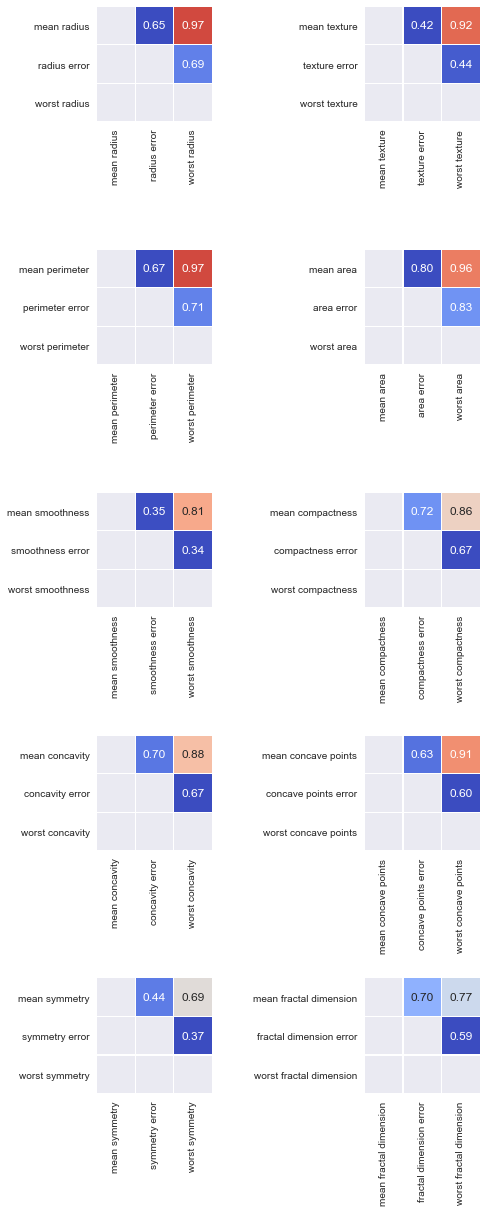

In [14]:
feature_map = [[x, y, z] for x, y, z in zip(features_mean, features_se, features_worst)] # I love Python
f, axs = plt.subplots(5, 2, figsize=(8, 20))
f.subplots_adjust(hspace = 1.1, wspace= .5)

axs = axs.ravel()
for features, j in zip(feature_map, range(10)):
    corr = df[features].corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(corr, 
                cbar = False,  
                square = True, 
                annot = True, 
                fmt = '.2f',
                yticklabels = features, 
                mask = mask,
                cmap = 'coolwarm', 
                linewidths=.1,
                ax = axs[j])

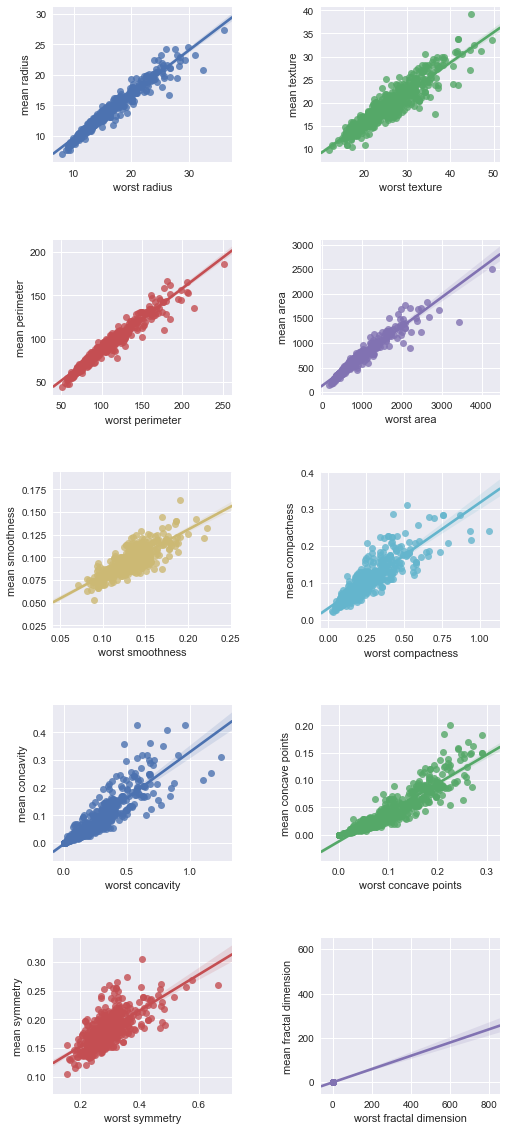

In [15]:
f, axs = plt.subplots(5, 2, figsize=(8, 20))
f.subplots_adjust(hspace = .5, wspace= .5)
axs = axs.ravel()
for features, j in zip(feature_map, range(10)):
    sns.regplot(x=features[2], y=features[0], data = df, ax = axs[j], fit_reg=True)

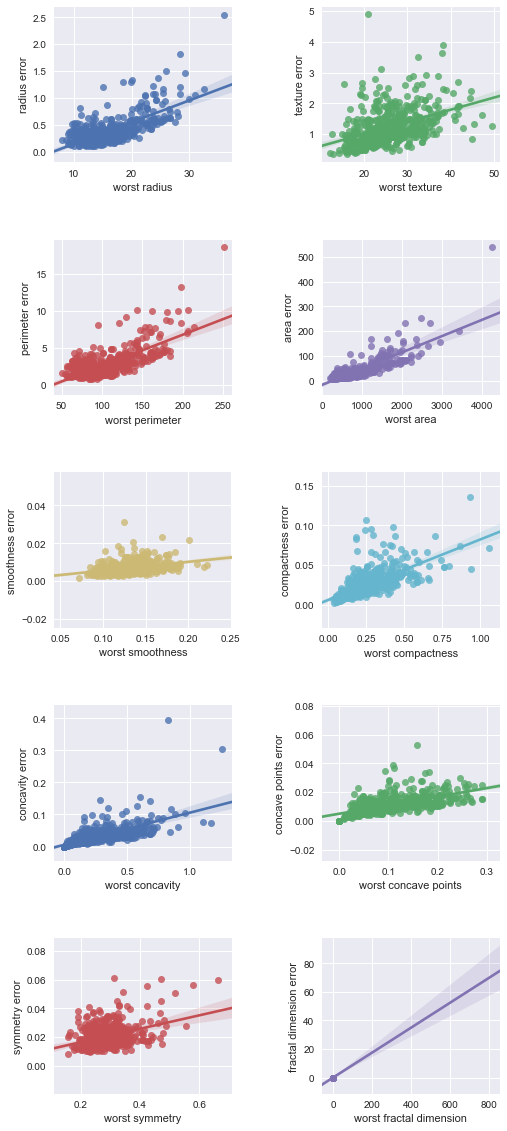

In [16]:
f, axs = plt.subplots(5, 2, figsize=(8, 20))
f.subplots_adjust(hspace = .5, wspace= .5)
axs = axs.ravel()
for features, j in zip(feature_map, range(10)):
    sns.regplot(x=features[2], y=features[1], data = df, ax = axs[j], fit_reg=True)

### Relaciones entre atributos de un mismo bloque

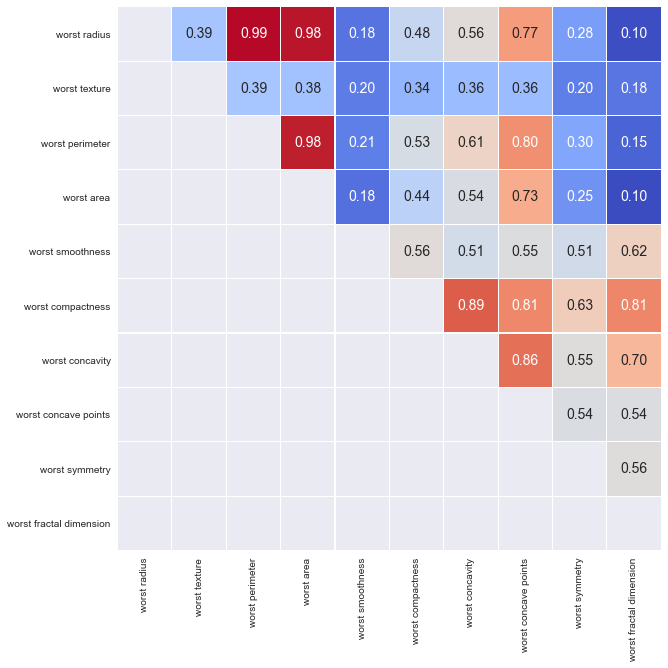

In [17]:
corr = df[features_worst].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 14},
           xticklabels= features_worst, yticklabels= features_worst, mask=mask,
           cmap= 'coolwarm', linewidths=.1)

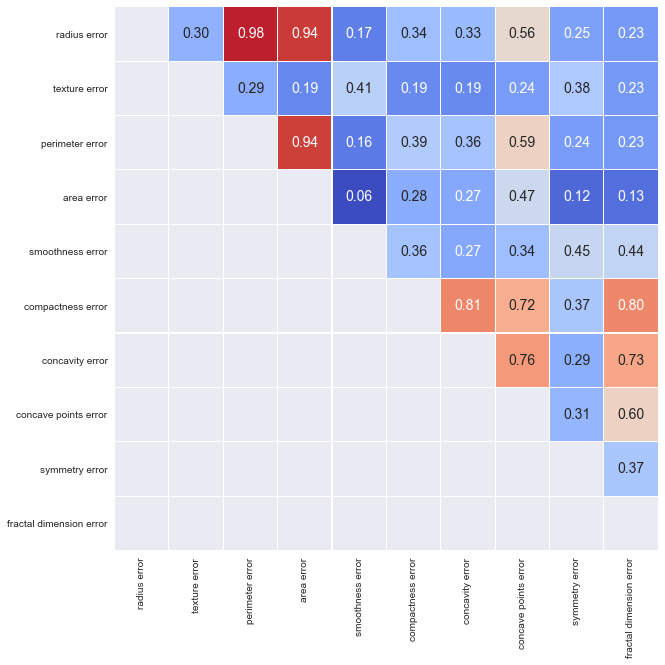

In [18]:
corr = df[features_se].corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.tril_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, cbar = False,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 14},
           xticklabels= features_se, yticklabels= features_se, mask=mask,
           cmap= 'coolwarm', linewidths=.1)

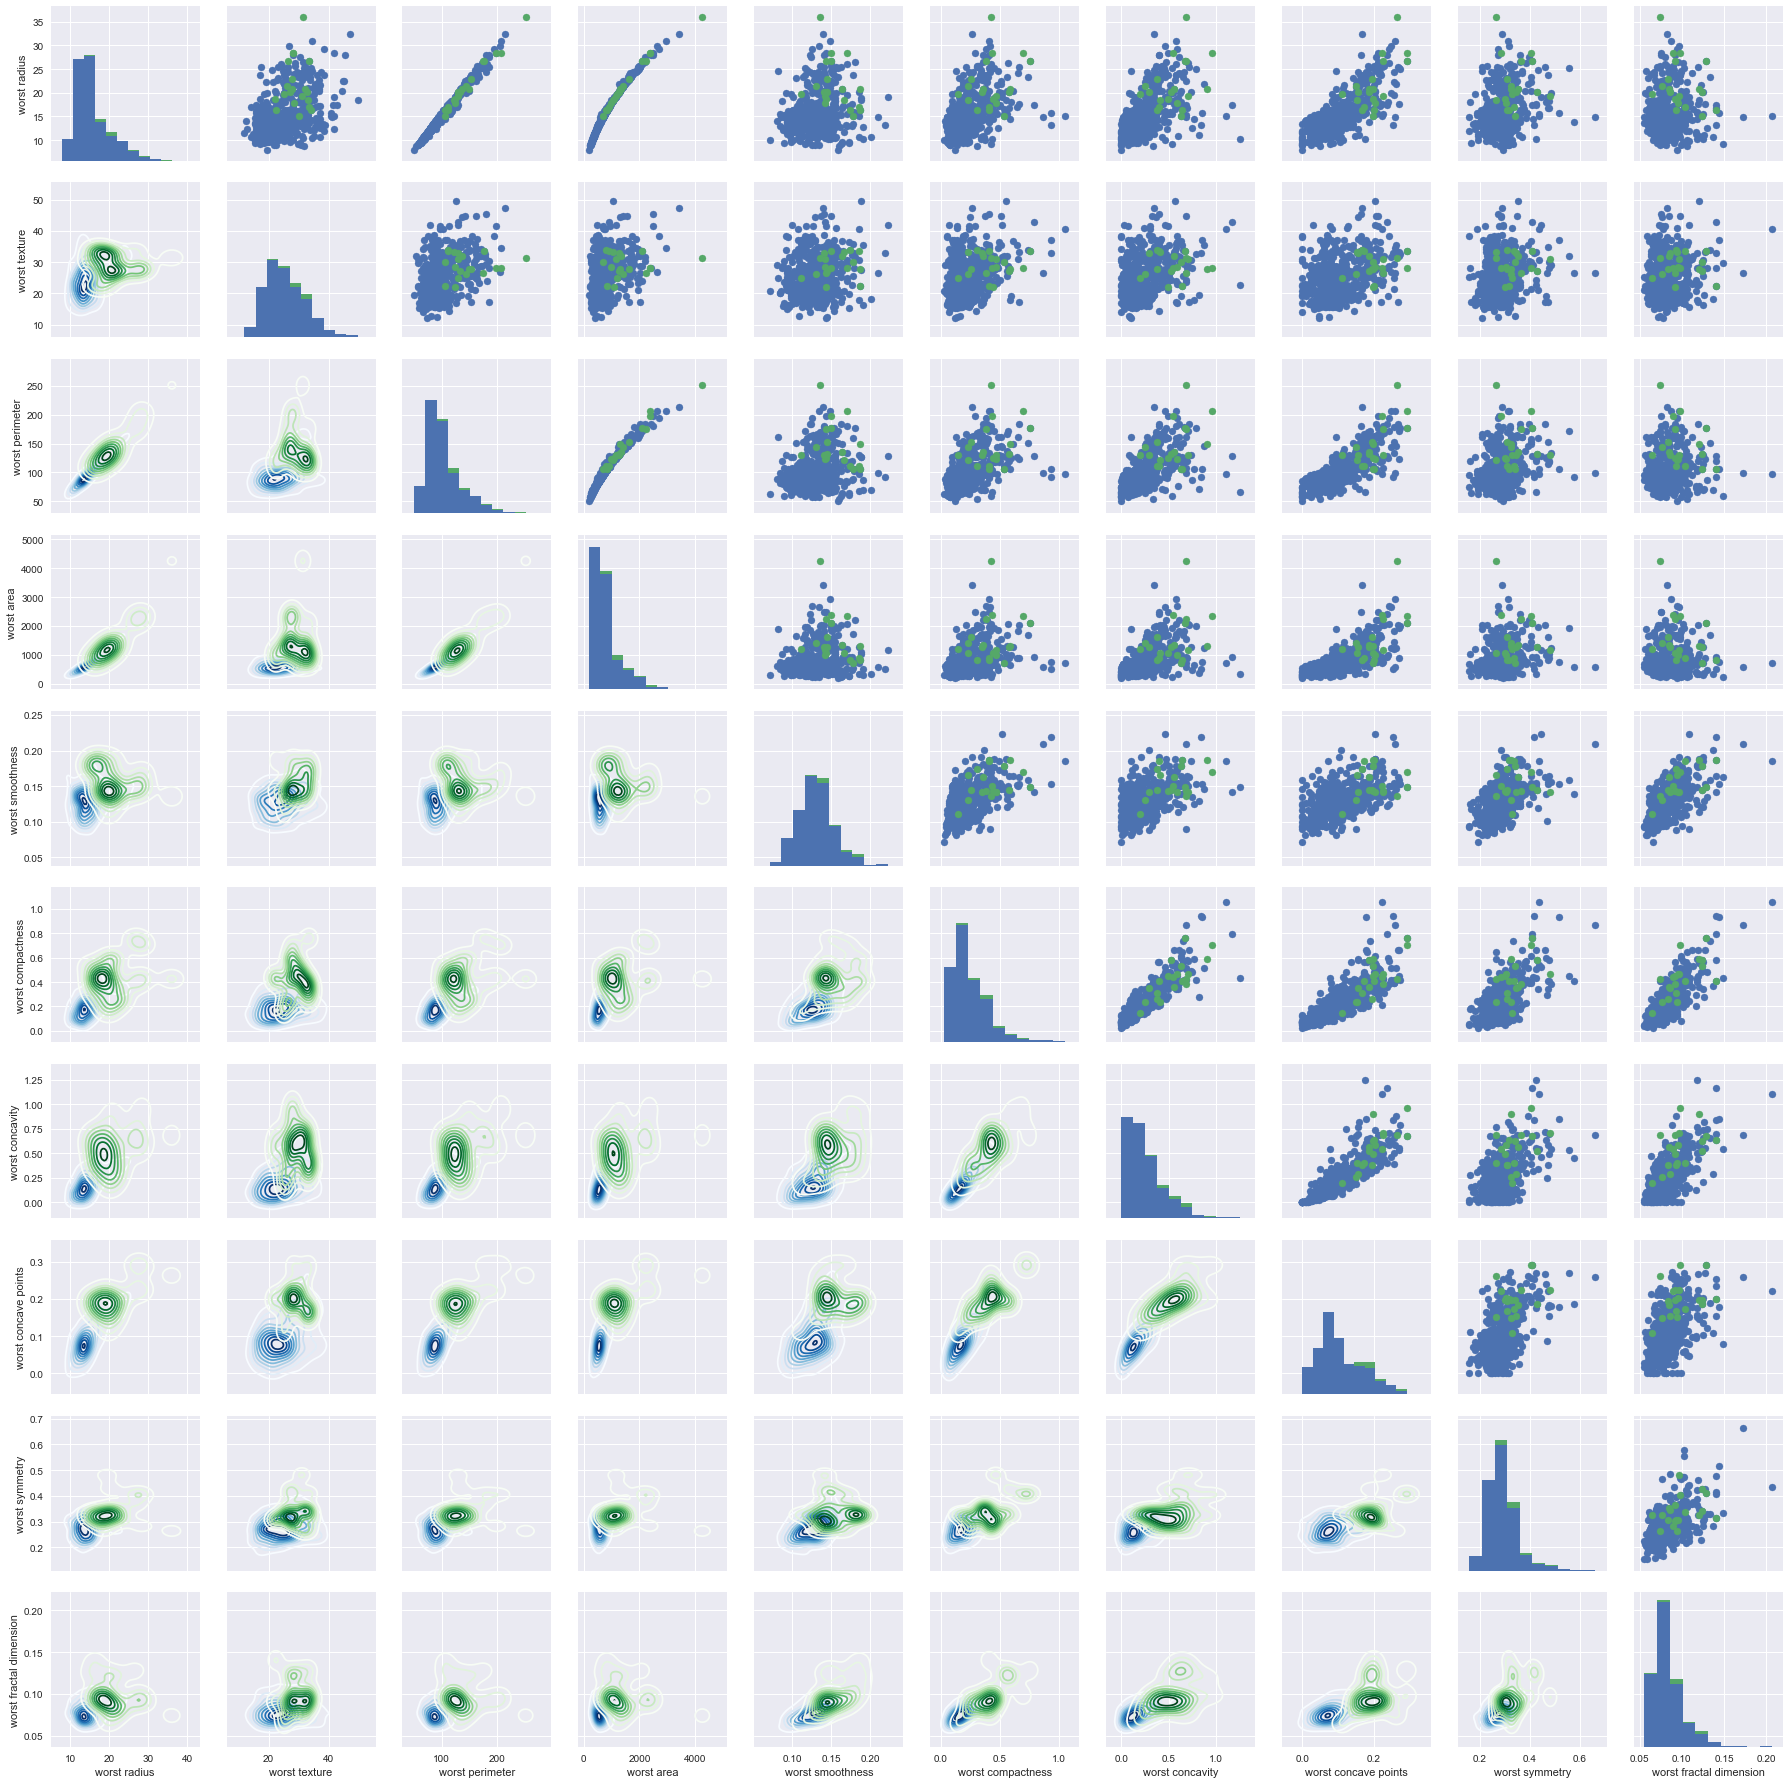

In [19]:
g = sns.PairGrid(df, vars=features_worst, hue='class', hue_kws={"cmap": ["Blues", "Greens"]})
g = g.map_diag(plt.hist)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, lw=1)
plt.show()

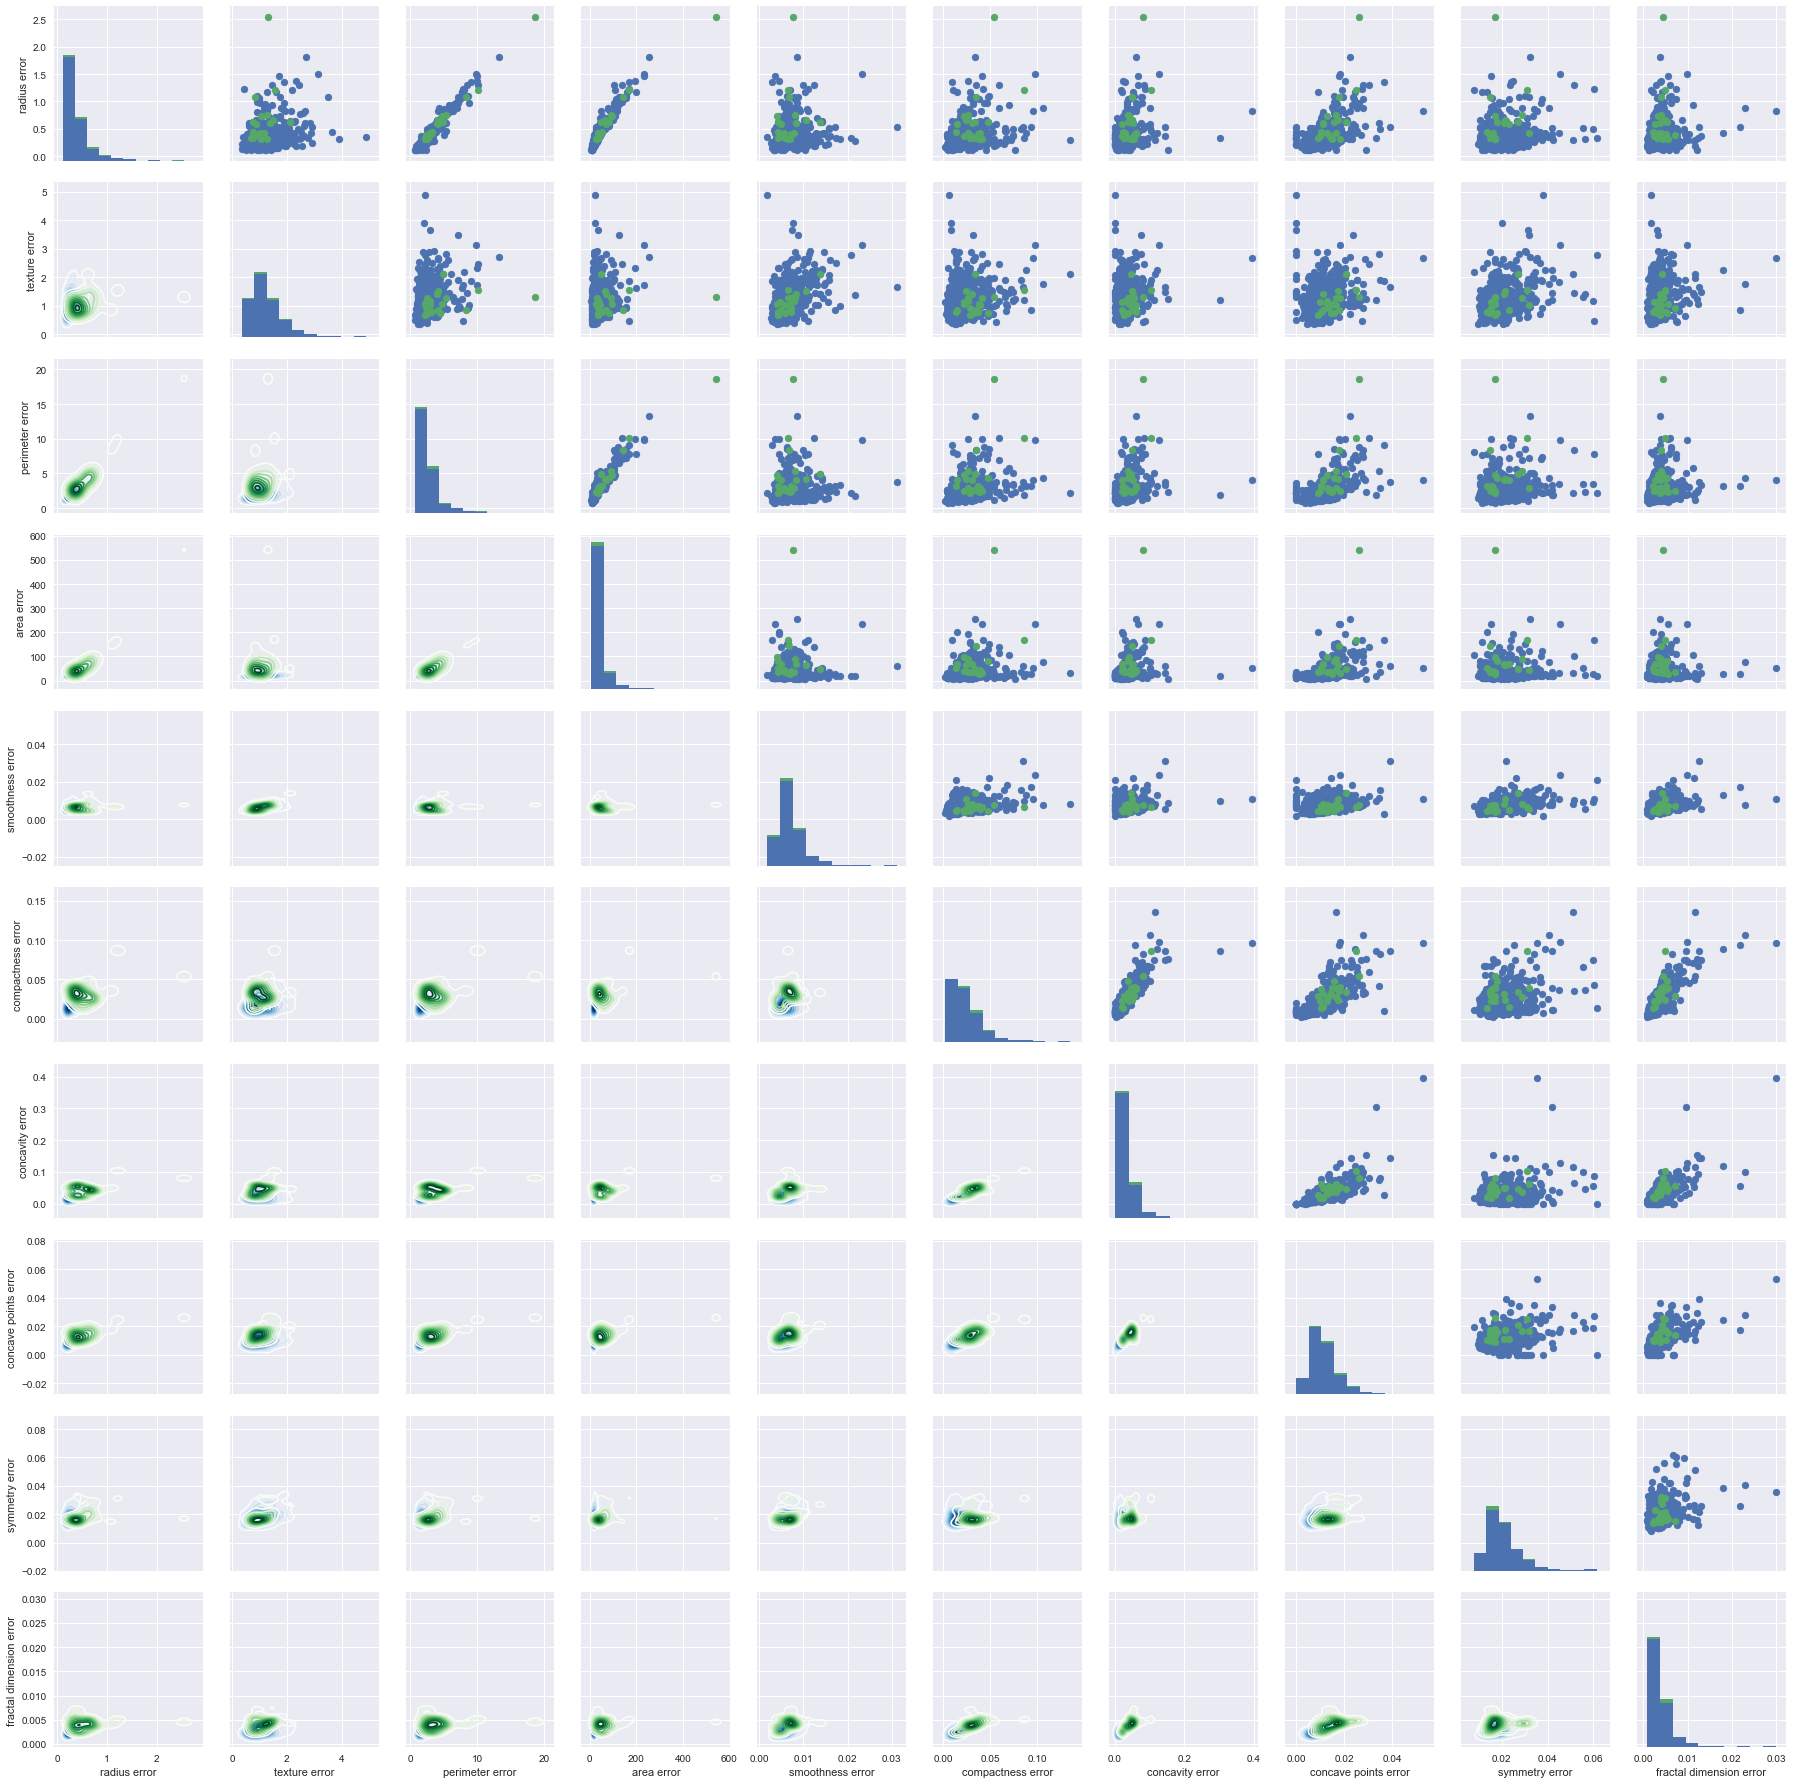

In [20]:
# O realizar un análisis de correlación
g = sns.PairGrid(df, vars=features_se, hue='class', hue_kws={"cmap": ["Blues", "Greens"]})
g = g.map_diag(plt.hist)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, lw=1)
plt.show()

## 4. Selección de variables

### Selección univariante

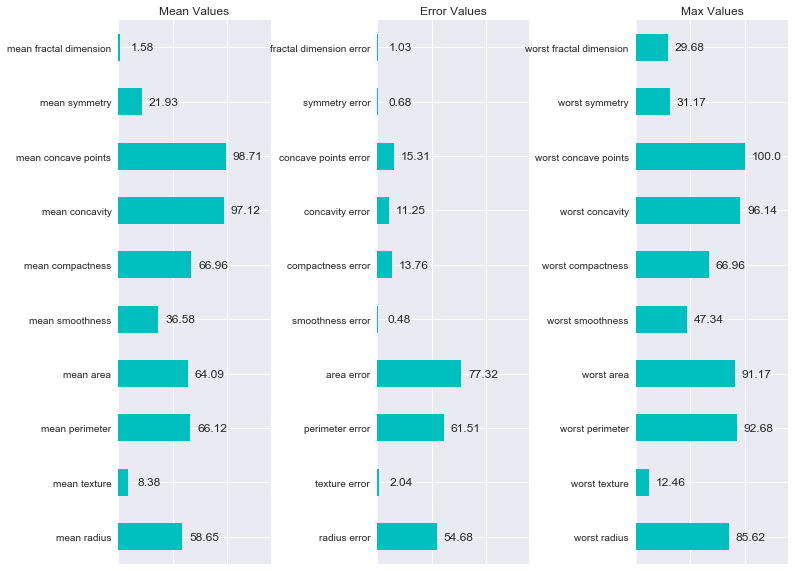

In [23]:
select_k_best_classifier = SelectKBest(score_func = f_classif).fit(X, y)
feature_importance = 100.0 * (select_k_best_classifier.scores_ / select_k_best_classifier.scores_.max())

anova_selection = pd.DataFrame(feature_importance, columns=['feature_importance'], index=[feature for feature in feature_names if feature not in ['class']])

f, axs = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(12,10))

f.subplots_adjust(wspace = .7)

anova_selection[anova_selection.index.isin(features_mean)].plot(kind='barh', legend=False, ax=axs[0], title="Mean Values", color="c")

anova_selection[anova_selection.index.isin(features_se)].plot(kind='barh', legend=False, ax=axs[1], title="Error Values", color="c")

anova_selection[anova_selection.index.isin(features_worst)].plot(kind='barh', legend=False, ax=axs[2], title="Max Values", color="c")

for j in range(3):
    axs[j].set_xlim(0,140)
    axs[j].set_xticklabels([])
    rects = axs[j].patches
    # Now make some labels
    labels = ["label%d" % i for i in range(len(rects))]
    for rect, label in zip(rects, feature_map):
        width = rect.get_width()
        axs[j].text(width+20, rect.get_y()+.25, round(anova_selection[anova_selection.index.isin([label[j]])].values[0][0], 2), ha='center', va='center')

In [65]:
selected_features = ['worst texture', 'worst area', 'worst smoothness', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'texture error', 'area error', 'smoothness error', 'concave points error', 'symmetry error', 'fractal dimension error']

In [66]:
df_reduced =df[[feature for feature in df.columns if feature in selected_features]]

X_reduced = df_reduced.as_matrix([feature for feature in df_reduced.columns if feature not in ['class']])

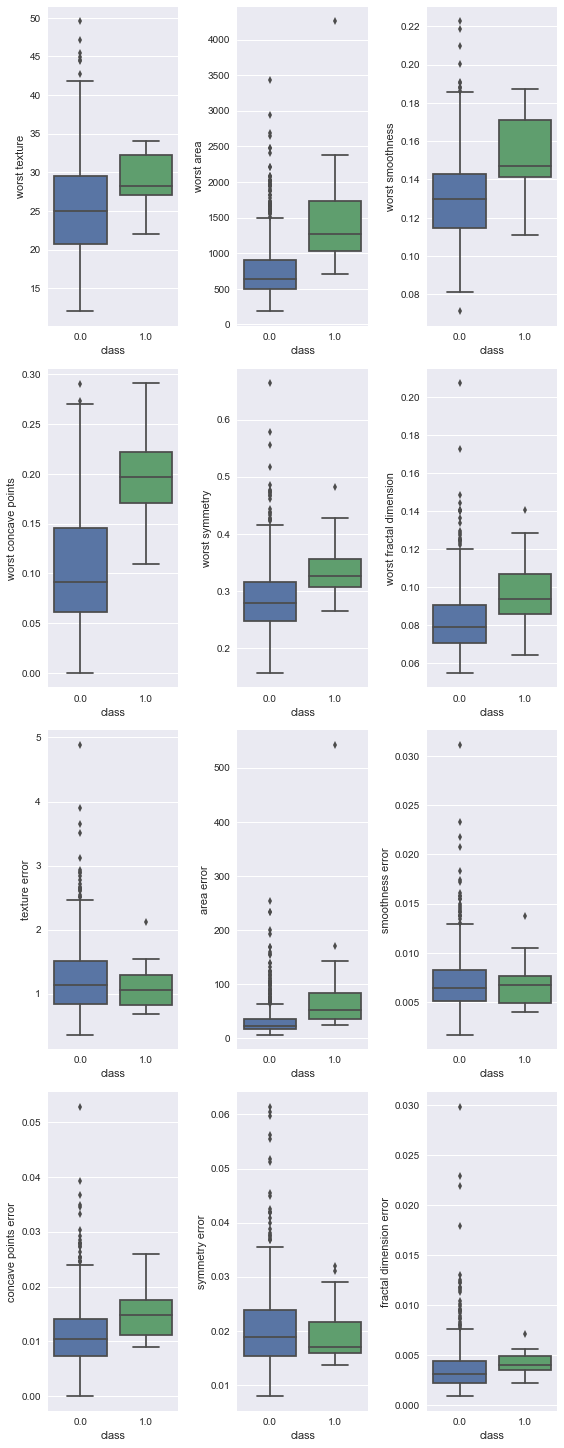

In [67]:
plt.figure(figsize=(8, 50))
for column_index, column in enumerate(selected_features):
    if column == 'class':
        continue
    plt.subplot(10, 3, column_index + 1)
    sns.boxplot(x='class', y=column, data=df)
plt.tight_layout()

/Users/juanaguila/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


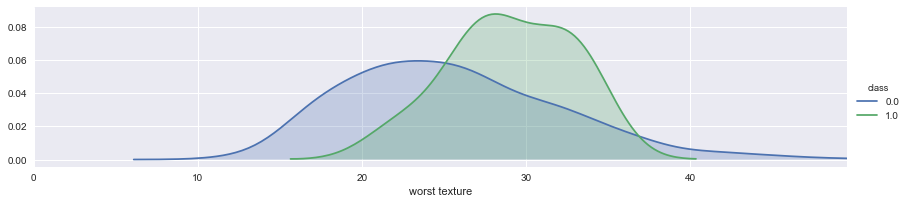

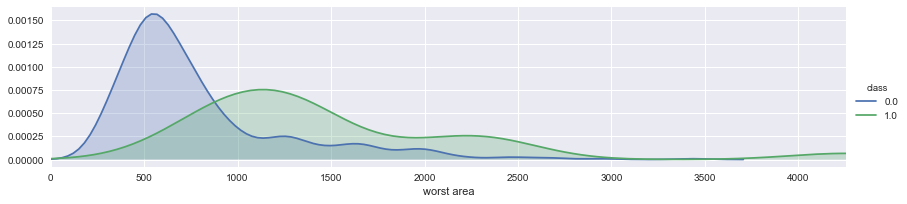

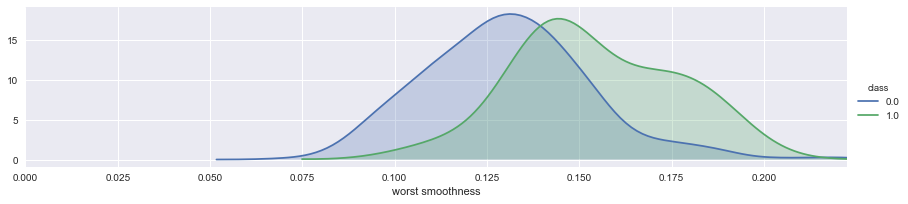

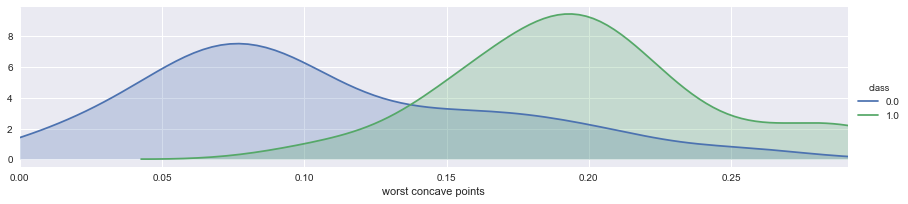

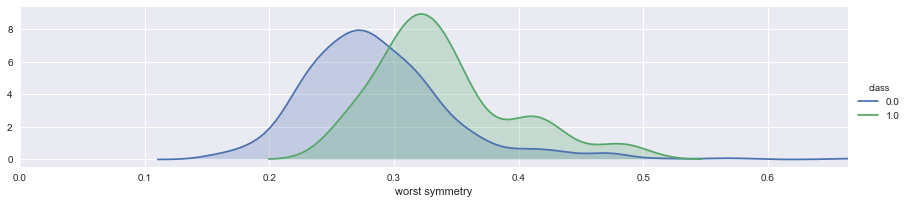

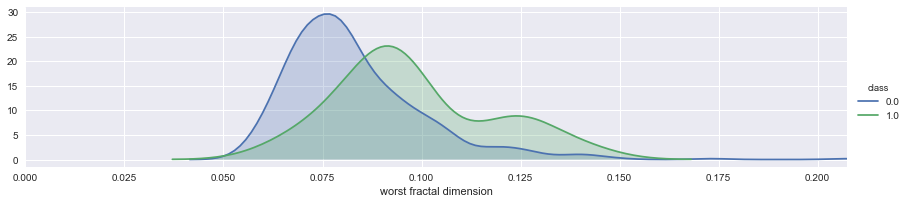

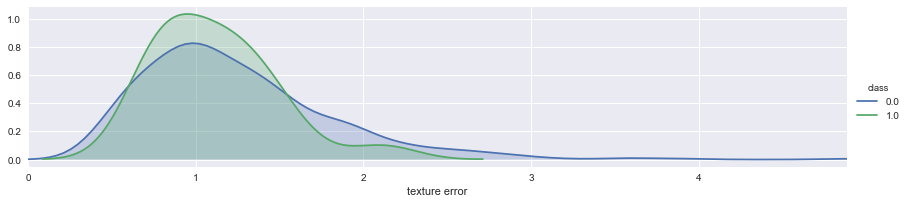

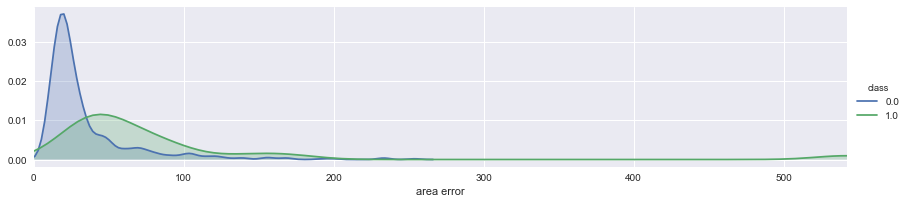

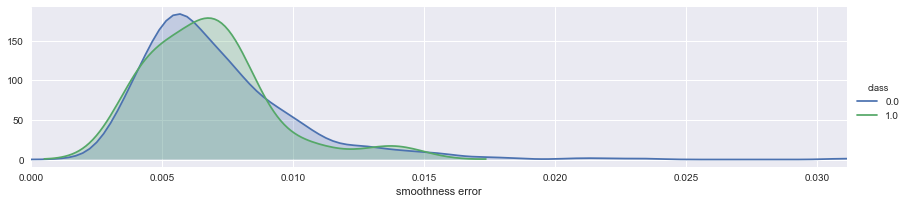

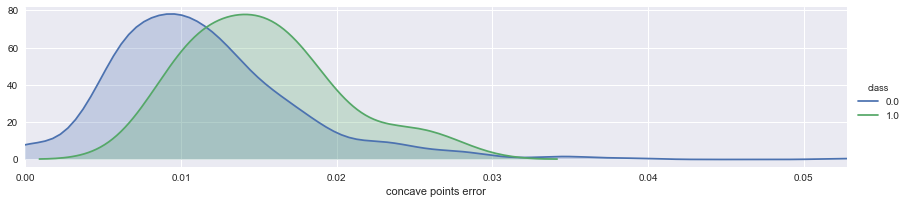

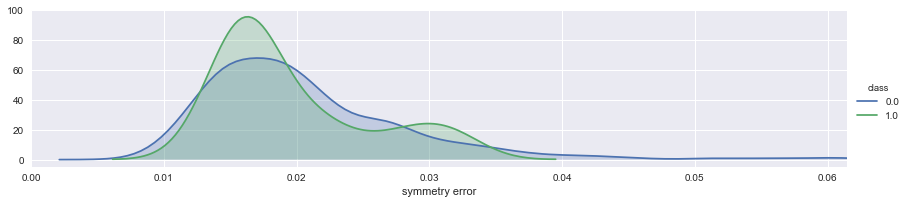

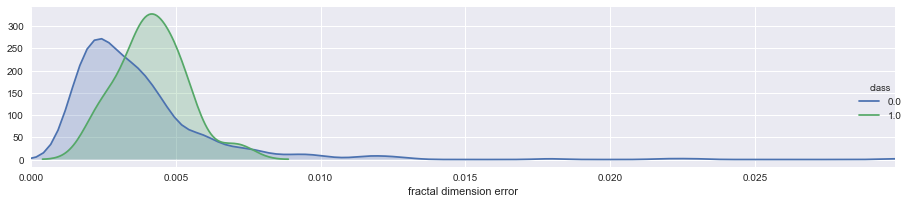

In [68]:
for column_index, column in enumerate(selected_features):
    if column == 'class':
        continue
    plt.figure(figsize=(8, 50))
    facet = sns.FacetGrid(df, hue="class",aspect=4)
    facet.map(sns.kdeplot,column,shade= True)
    facet.set(xlim=(0, df[column].max()))
    facet.add_legend()
plt.tight_layout()

In [81]:
df_selected.head()

,area error,smoothness error,symmetry error,fractal dimension error,worst texture
0,89.74,0.007997,0.02897,0.003996,26.06
1,81.46,0.004253,0.01798,0.005295,33.48
2,49.70,0.013800,0.02689,0.004306,34.01
3,45.50,0.005635,0.03197,0.004085,31.03
4,36.46,0.007781,0.01635,0.003601,33.47


## 5. Análisis de componentes principales

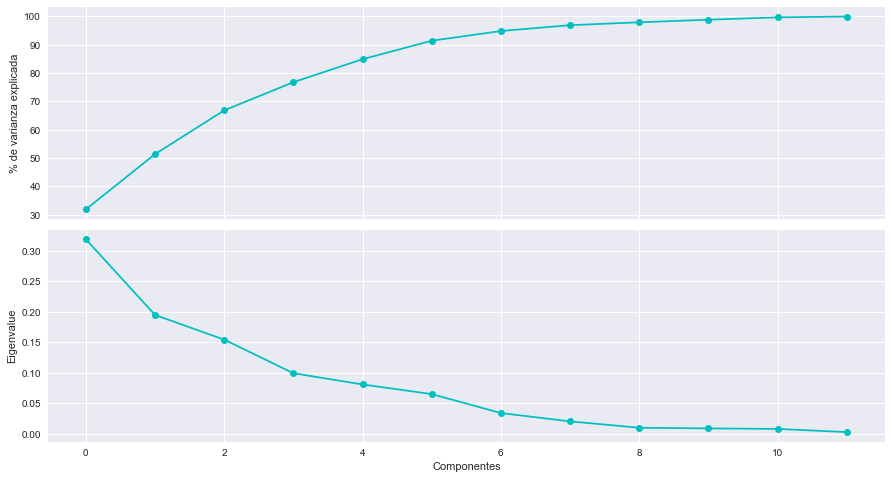

In [69]:
X_scaled = StandardScaler().fit(X_reduced).transform(X_reduced)

pca = PCA()
pca.fit(X_scaled)
pca_projection = pca.transform(X_scaled)

var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15,8))
f.subplots_adjust(hspace = .05)
axarr[0].plot(var, '-o', color="c")
axarr[0].set_ylabel('% de varianza explicada')
axarr[1].plot(pca.explained_variance_ratio_, '-o', color="c")
axarr[1].set_ylabel('Eigenvalue')
axarr[1].set_xlabel('Componentes')

In [70]:
X_projected = pca_projection[:,:5]
df_projected = pd.DataFrame(
                    data = np.c_[X_projected, y], 
                    columns = np.append(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], ['class'])
                )

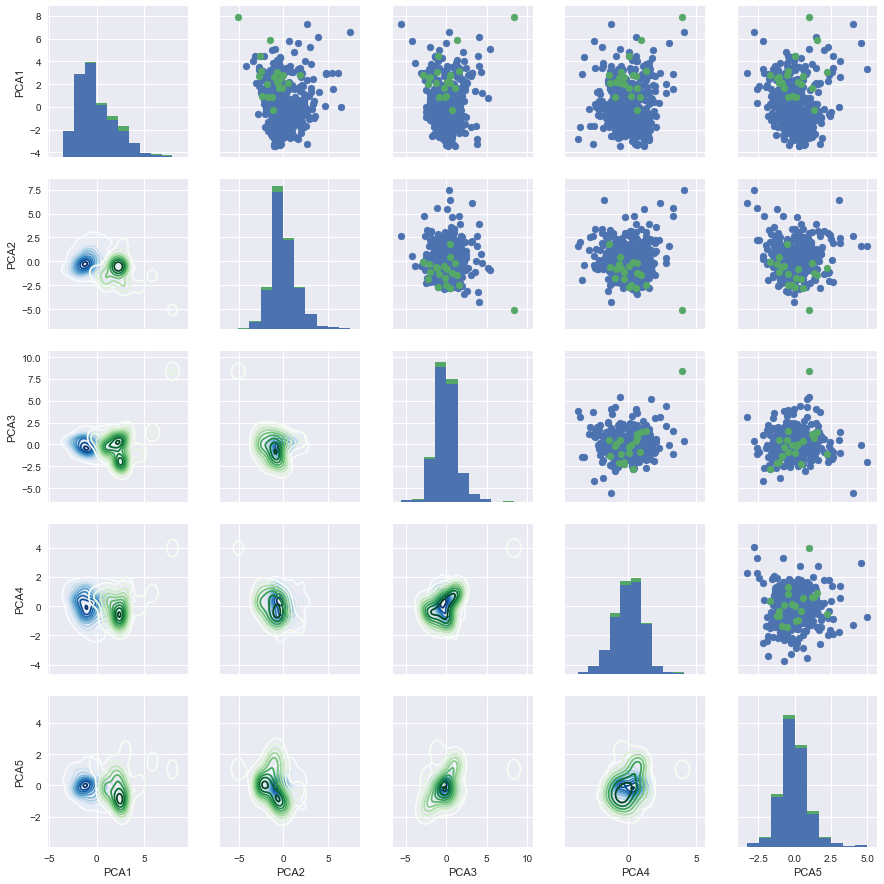

In [71]:
# O realizar un análisis de correlación
g = sns.PairGrid(df_projected, vars=['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5'], hue='class', hue_kws={"cmap": ["Blues", "Greens"]})
g = g.map_diag(plt.hist)
g = g.map_upper(plt.scatter)
g = g.map_lower(sns.kdeplot, lw=1)
plt.show()

In [82]:
df_projected.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,class
0,1.626628,-0.148899,1.150631,0.611832,1.200477,1.0
1,4.499242,-2.671206,-0.984192,0.015034,0.042542,1.0
2,2.777942,1.805973,0.517180,-1.414073,-0.501605,1.0
3,3.038655,-0.727062,-1.149256,-0.521539,2.256033,1.0
4,2.106866,-0.634253,-1.297276,-1.359228,-0.827237,1.0


## 6. Modelado

### Funciones auxiliares

In [84]:
class DummySampler(object):

    def sample(self, X, y):
        return X, y

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return self.sample(X, y)

In [85]:
import matplotlib
font = {'size'   : 32}
matplotlib.rc('font', **font)

### Estandarización de variables

In [99]:
X_scaled = StandardScaler().fit(X).transform(X)
X_reduced_scaled = StandardScaler().fit(X_reduced).transform(X_reduced)
X_selected_scaled = StandardScaler().fit(X_selected).transform(X_selected)

### Atributos de entrada

/Users/juanaguila/anaconda/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


Original dataset - 30 attributes completed!
Reduced dataset - 12 attributes completed!
PCA - 5 components completed!
Selected features - 5 attributes completed!


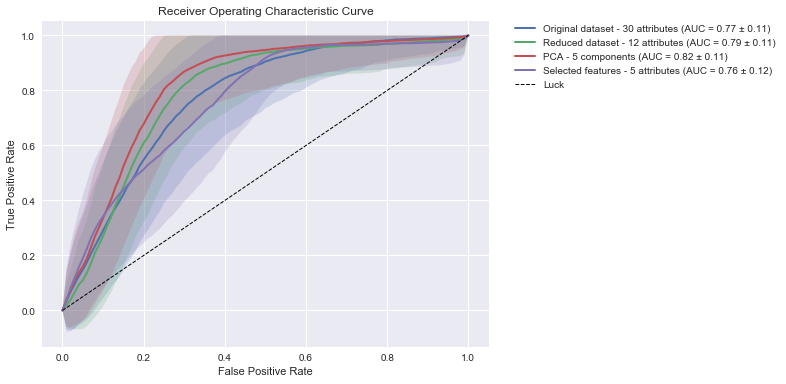

In [100]:
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
sampler = ['Standard', DummySampler()]

from imblearn.pipeline import make_pipeline

pipeline = make_pipeline(sampler[1], 
                         classifier[1])

n_bootstraps = 1000
test_size = 0.35
X_values = [
    ['Original dataset - 30 attributes', X_scaled],
    ['Reduced dataset - 12 attributes', X_reduced_scaled],
    ['PCA - 5 components', X_projected],
    ['Selected features - 5 attributes', X_selected_scaled]
]

plt.figure(figsize=(8,6))

for name, dummy_X in X_values:

    tprs = []
    bootstrapped_aucs = []
    base_fpr = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        X_train, X_test, y_train, y_test = train_test_split(dummy_X, y, test_size=test_size, random_state=RANDOM_STATE+i, stratify=y)
        X_train, y_train = resample(X_train, y_train, random_state=RANDOM_STATE+i) #Boostrap sampling
        X_test, y_test = resample(X_test, y_test, random_state=RANDOM_STATE+i) #Boostrap sampling
        _y_values = Counter(y_test).keys()
        if len(_y_values) == 1: 
            continue
        model = pipeline.fit(X_train, y_train)
        probas_ = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
        auc = roc_auc_score(y_test, probas_[:,1])
        bootstrapped_aucs.append(auc)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
    tprs_lower = mean_tprs - std_tprs

    bootstrapped_aucs = np.array(bootstrapped_aucs)
    mean_auc = bootstrapped_aucs.mean(axis=0)
    std_auc = bootstrapped_aucs.std(axis=0)

    plt.plot(base_fpr, mean_tprs, label="{name} (AUC = {mean:0.2f} ± {std:0.2f})".format(name=name, mean=mean_auc, std=std_auc), lw=2*LW)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2)
    print(name+" completed!")

plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Baseline model

In [101]:
new_X = X_projected
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]

Standard-Perceptron completed!


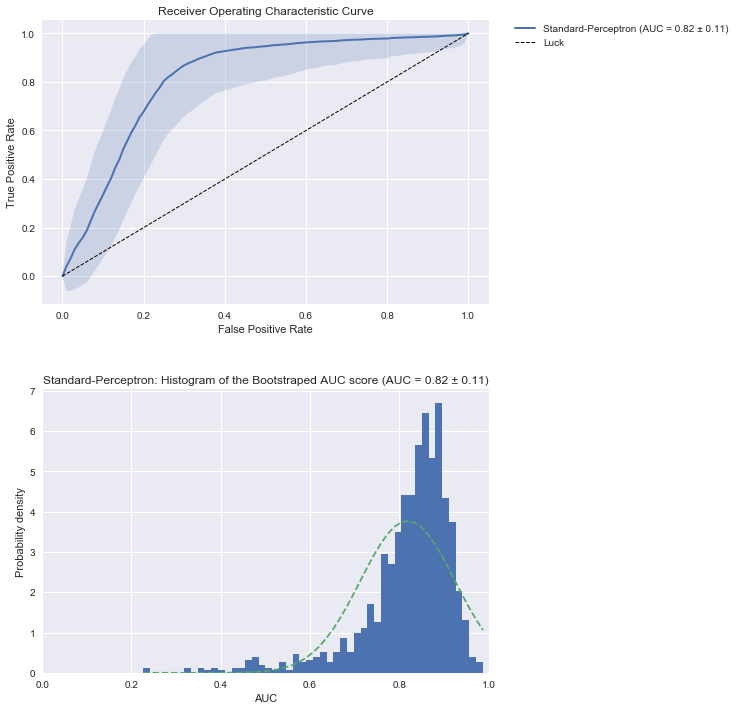

In [102]:
samplers = [
    ['Standard', DummySampler()]
]

from imblearn.pipeline import make_pipeline

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

n_bootstraps = 1000
test_size = 0.35 

f, axarr = plt.subplots(2, figsize=(8,12))
f.subplots_adjust(hspace = .3, wspace= .5)

for name, pipeline in pipelines:

    tprs = []
    bootstrapped_aucs = []
    base_fpr = np.linspace(0, 1, 101)
    for i in range(n_bootstraps):
        X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=test_size, random_state=RANDOM_STATE+i, stratify=y)
        #Boostrap sampling
        X_train, y_train = resample(X_train, y_train, random_state=RANDOM_STATE+i)
        X_test, y_test = resample(X_test, y_test, random_state=RANDOM_STATE+i)
        _y_values = Counter(y_test).keys()
        if len(_y_values) == 1: 
            continue
        model = pipeline.fit(X_train, y_train)
        probas_ = model.predict_proba(X_test)
        fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
        auc = roc_auc_score(y_test, probas_[:,1])
        bootstrapped_aucs.append(auc)
        #plt.plot(fpr, tpr, 'b', alpha=0.15)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        #plt.plot(fpr, tpr, label='{name} (Area = {area:0.2f}'.format(name=name, area=auc), lw=LW)

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std_tprs = tprs.std(axis=0)
    tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
    tprs_lower = mean_tprs - std_tprs

    bootstrapped_aucs = np.array(bootstrapped_aucs)
    mean_auc = bootstrapped_aucs.mean(axis=0)
    std_auc = bootstrapped_aucs.std(axis=0)

    axarr[0].plot(base_fpr, mean_tprs, label="{name} (AUC = {mean:0.2f} ± {std:0.2f})".format(name=name, mean=mean_auc, std=std_auc), lw=LW*2)
    axarr[0].fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2)
    print(name+" completed!")

axarr[0].plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')

axarr[0].set_xlabel('False Positive Rate')
axarr[0].set_ylabel('True Positive Rate')
axarr[0].set_title('Receiver Operating Characteristic Curve')

axarr[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

num_bins = 50

# the histogram of the data
n, bins, patches = plt.hist(bootstrapped_aucs, num_bins, normed=1)

# add a 'best fit' line
auc_density = mlab.normpdf(bins, mean_auc, std_auc)
axarr[1].plot(bins, auc_density, '--')
axarr[1].set_xlabel('AUC')
axarr[1].set_ylabel('Probability density')
axarr[1].set_xlim([0,1])
axarr[1].set_title("{name}: Histogram of the Bootstraped AUC score (AUC = {mean:0.2f} ± {std:0.2f})".format(name=name, mean=mean_auc, std=std_auc))

### Definición de la función

In [103]:
def benchmarks(pipelines, X, y, n_bootstraps, test_size):

    plt.figure(figsize=(8,6))
    
    for name, pipeline in pipelines:

        tprs = []
        bootstrapped_aucs = []
        base_fpr = np.linspace(0, 1, 101)
        for i in range(n_bootstraps):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=RANDOM_STATE+i, stratify=y)
            #Boostrap sampling
            X_train, y_train = resample(X_train, y_train, random_state=RANDOM_STATE+i)
            if len(y_train[y_train==1]) < 3:
                continue
            X_test, y_test = resample(X_test, y_test, random_state=RANDOM_STATE+i)
            _y_values = Counter(y_test).keys()
            if len(_y_values) == 1: 
                continue
            model = pipeline.fit(X_train, y_train)
            probas_ = model.predict_proba(X_test)
            fpr, tpr, _ = roc_curve(y_test, probas_[:,1])
            auc = roc_auc_score(y_test, probas_[:,1])
            bootstrapped_aucs.append(auc)
            #plt.plot(fpr, tpr, 'b', alpha=0.15)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
            #plt.plot(fpr, tpr, label='{name} (Area = {area:0.2f}'.format(name=name, area=auc), lw=LW)

        tprs = np.array(tprs)
        mean_tprs = tprs.mean(axis=0)
        std_tprs = tprs.std(axis=0)
        tprs_upper = np.minimum(mean_tprs + std_tprs, 1)
        tprs_lower = mean_tprs - std_tprs

        bootstrapped_aucs = np.array(bootstrapped_aucs)
        mean_auc = bootstrapped_aucs.mean(axis=0)
        std_auc = bootstrapped_aucs.std(axis=0)

        plt.plot(base_fpr, mean_tprs, label="{name} (AUC = {mean:0.2f} ± {std:0.2f})".format(name=name, mean=mean_auc, std=std_auc), lw=2*LW)
        plt.fill_between(base_fpr, tprs_lower, tprs_upper, alpha=0.2)
        print(name+" completed!")

    plt.plot([0, 1], [0, 1], linestyle='--', lw=LW, color='k', label='Luck')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Oversampling

In [104]:
samplers = [
    ['Standard', DummySampler()],
    # OverSamplers
    ['bSMOTE', over_sampling.RandomOverSampler(random_state=RANDOM_STATE)],
    ['SMOTE', over_sampling.SMOTE(random_state=RANDOM_STATE, m_neighbors=3, k_neighbors=3)],
    ['ADASYN', over_sampling.ADASYN(random_state=RANDOM_STATE, n_neighbors=3)],
    ['ROS', over_sampling.SMOTE(random_state=RANDOM_STATE, kind='borderline1', m_neighbors=3, k_neighbors=3)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

Standard-Perceptron completed!
bSMOTE-Perceptron completed!
SMOTE-Perceptron completed!
ADASYN-Perceptron completed!
ROS-Perceptron completed!


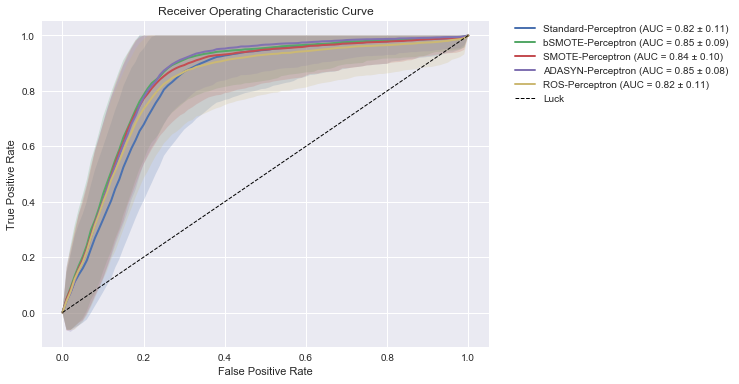

In [105]:
n_bootstraps = 1000
test_size = 0.35 
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
benchmarks(pipelines, new_X, y, n_bootstraps, test_size)

### Undersampling

In [106]:
samplers = [
    ['Standard', DummySampler()],
    # OverSamplers
    ['OSS', under_sampling.OneSidedSelection(random_state=RANDOM_STATE)],
    ['NM1', under_sampling.NearMiss(random_state=RANDOM_STATE, version=1)],
    ['ClC', under_sampling.ClusterCentroids(random_state=RANDOM_STATE)],
    ['RUS', under_sampling.RandomUnderSampler(random_state=RANDOM_STATE)]

]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

Standard-Perceptron completed!
OSS-Perceptron completed!
NM1-Perceptron completed!
ClC-Perceptron completed!
RUS completed!


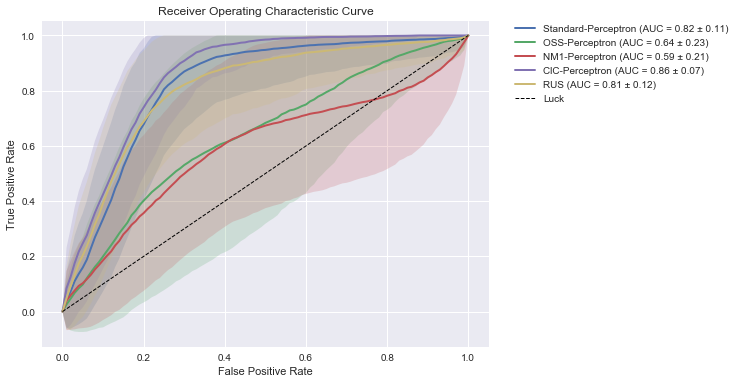

In [107]:
n_bootstraps = 1000
test_size = 0.35 
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
benchmarks(pipelines, new_X, y, n_bootstraps, test_size)

### Limpieza

In [108]:
samplers = [
    ['Standard', DummySampler()],
    # Limpieza
    ['TL', under_sampling.TomekLinks(random_state=RANDOM_STATE)],
    ['NCL', under_sampling.NeighbourhoodCleaningRule(random_state=RANDOM_STATE)],
    ['ENN', under_sampling.EditedNearestNeighbours(random_state=RANDOM_STATE)],
    ['CNN', under_sampling.CondensedNearestNeighbour(random_state=RANDOM_STATE)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

Standard-Perceptron completed!
TL-Perceptron completed!
NCL-Perceptron completed!
ENN-Perceptron completed!
CNN-Perceptron completed!


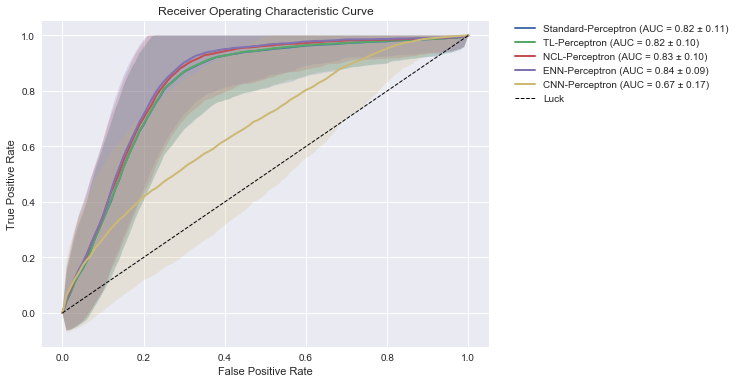

In [109]:
n_bootstraps = 1000
test_size = 0.35 
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
benchmarks(pipelines, new_X, y, n_bootstraps, test_size)

### OverUnderSampling

In [110]:
samplers = [
    ['Standard', DummySampler()],
    # OverUnderSamplers
    ['SMOTE-ENN', combine.SMOTEENN(random_state=RANDOM_STATE, n_neighbors=3, k=3, m=3)],
    ['SMOTE-TL', combine.SMOTETomek(random_state=RANDOM_STATE, k=3, m=3)],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

Standard-Perceptron completed!
SMOTE-ENN-Perceptron completed!
SMOTE-TL-Perceptron completed!


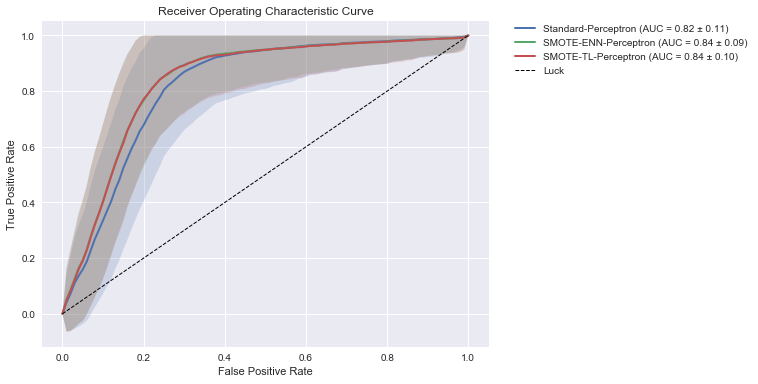

In [111]:
n_bootstraps = 1000
test_size = 0.35 
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
benchmarks(pipelines, new_X, y, n_bootstraps, test_size)

### Ensemble

In [112]:
samplers = [
    ['Standard', DummySampler()],
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], 
             classifier[1])]
    for sampler in samplers
]

# Bagging
bagging_estimators = 10
pipelines.append(['RUS', make_pipeline(StandardScaler(), BaggingClassifier(base_estimator=estimator, n_estimators=bagging_estimators, random_state=RANDOM_STATE))])

# AdaBoost
#boosting_estimators = 10
#pipelines.append(['Boosting', make_pipeline(StandardScaler(), AdaBoostClassifier(n_estimators=boosting_estimators, base_estimator=estimator, random_state=RANDOM_STATE))])

Standard-Perceptron completed!
Bagging-Perceptron completed!


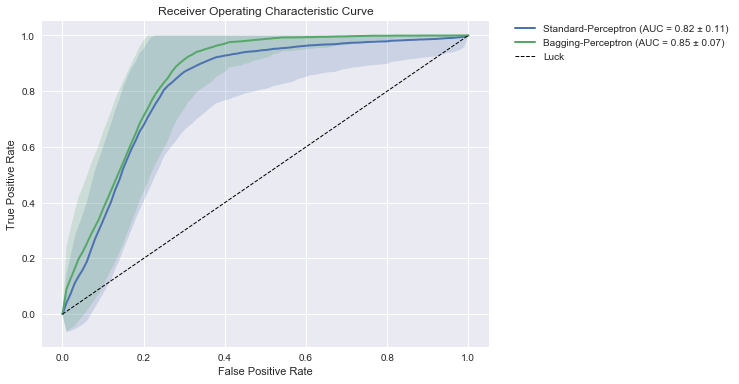

In [113]:
n_bootstraps = 1000
test_size = 0.35 
estimator = MLPClassifier(hidden_layer_sizes=(12, 6), random_state=RANDOM_STATE+50)
classifier = ['Perceptron', estimator]
benchmarks(pipelines, new_X, y, n_bootstraps, test_size)